<a href="https://colab.research.google.com/github/Meridor6919/Ascii-converter/blob/master/AngularPowerSpectraWeightProjAdamTestSmallAngle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import math
from copy import deepcopy

from drive.MyDrive.Matis.Cone import Cone
from drive.MyDrive.Matis.Adam import Adam
from drive.MyDrive.Matis.ProjType import ProjType
from drive.MyDrive.Matis.ConeProj import ConeProj
from drive.MyDrive.Matis.MatlabLoader import Loader
from drive.MyDrive.Matis.Autoencoder import Autoencoder as AE

In [ ]:
np.random.seed(2173)
torch.manual_seed(2713)

torch.autograd.set_detect_anomaly(True)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1237)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
batch_size = 32
data_dimension = 180

root_dir = "drive/MyDrive/Matis/TrainData"
loader = Loader(root_dir=root_dir, cache=True, device='cpu')
loader.create_table()
data_loader = torch.utils.data.DataLoader(loader, batch_size=batch_size, shuffle=True)
get_data = lambda feature: feature['aps'].to(device).float()

<class 'numpy.ndarray'>
Loaded 50000 samples


In [ ]:
dim_layers = [ data_dimension, 200, 40, 200 ]
activ_funcs = [ nn.Tanh(), nn.Tanh(), nn.Tanh(), nn.ReLU() ]
input_shape = dim_layers[0]
cone_angle_func = lambda n : (np.pi / 4) * 0.8 + (np.arccos(1.0 / np.sqrt(n))) * 0.2

normal_model = AE(activ_funcs = activ_funcs, dim_layers = deepcopy(dim_layers)).to(device)
cone_model = deepcopy(normal_model)
clamp_model = deepcopy(normal_model)
cone_t_model = deepcopy(normal_model)

learning_rate = 0.001
normal_optimizer = Adam(normal_model.parameters(), lr=learning_rate, proj_type=ProjType.NONE)
cone_optimizer = Adam(cone_model.parameters(), lr=learning_rate, cone_angle_func = cone_angle_func, proj_type=ProjType.CONE)
clamp_optimizer = Adam(clamp_model.parameters(), lr=learning_rate, proj_type=ProjType.CLAMP)
cone_t_optimizer = Adam(cone_t_model.parameters(), lr=learning_rate, cone_angle_func = cone_angle_func, proj_type=ProjType.CONE_TRANSPOSED)

In [ ]:
def loss_function(output, target):
  return torch.mean((output - target)**2)

In [ ]:
epochs = 20
normal_loss_total = []
cone_loss_total = []
clamp_loss_total = []
cone_t_loss_total = []

for epoch in range(epochs):
    normal_loss = 0
    cone_loss = 0
    clamp_loss = 0
    cone_t_loss = 0

    for batch_features in data_loader:
        batch_features = get_data(batch_features).to(device)

        normal_optimizer.zero_grad()
        cone_optimizer.zero_grad()
        cone_t_optimizer.zero_grad()
        clamp_optimizer.zero_grad()

        out_normal = normal_model(batch_features).to(device)
        train_loss_normal = loss_function(out_normal, batch_features)
        train_loss_normal.backward()
        normal_optimizer.step()
        normal_loss += train_loss_normal.item()

        out_cone = cone_model(batch_features).to(device)
        train_loss_cone = loss_function(out_cone, batch_features)
        train_loss_cone.backward()
        cone_optimizer.step()
        cone_loss += train_loss_cone.item()

        out_clamp = clamp_model(batch_features).to(device)
        train_loss_clamp = loss_function(out_clamp, batch_features)
        train_loss_clamp.backward()
        clamp_optimizer.step()
        clamp_loss += train_loss_clamp.item()

        out_cone_t = cone_t_model(batch_features).to(device)
        train_loss_cone_t = loss_function(out_cone_t, batch_features)
        train_loss_cone_t.backward()
        cone_t_optimizer.step()
        cone_t_loss += train_loss_cone_t.item()

    normal_loss_total.append(normal_loss / len(data_loader))
    cone_loss_total.append(cone_loss / len(data_loader))
    clamp_loss_total.append(clamp_loss / len(data_loader))
    cone_t_loss_total.append(cone_t_loss / len(data_loader))

    print("epoch : {}/{}, standard recon loss = {:.8f}".format(epoch + 1, epochs, normal_loss))
    print("epoch : {}/{}, cone recon loss = {:.8f}".format(epoch + 1, epochs, cone_loss))
    print("epoch : {}/{}, clamp recon loss = {:.8f}".format(epoch + 1, epochs, clamp_loss))
    print("epoch : {}/{}, cone transposed recon loss = {:.8f}".format(epoch + 1, epochs, cone_t_loss))

epoch : 1/20, standard recon loss = 233.27208850
epoch : 1/20, cone recon loss = 2470.02736771
epoch : 1/20, clamp recon loss = 1628.55574760
epoch : 1/20, cone transposed recon loss = 2414.73982739
epoch : 2/20, standard recon loss = 49.81718220
epoch : 2/20, cone recon loss = 1738.29493976
epoch : 2/20, clamp recon loss = 612.04593539
epoch : 2/20, cone transposed recon loss = 2233.21986258
epoch : 3/20, standard recon loss = 38.52152149
epoch : 3/20, cone recon loss = 1384.10249633
epoch : 3/20, clamp recon loss = 390.25719839
epoch : 3/20, cone transposed recon loss = 2216.56415939
epoch : 4/20, standard recon loss = 34.83186217
epoch : 4/20, cone recon loss = 1206.55196351
epoch : 4/20, clamp recon loss = 320.12322876
epoch : 4/20, cone transposed recon loss = 2225.50295758
epoch : 5/20, standard recon loss = 32.61758420
epoch : 5/20, cone recon loss = 1195.36329609
epoch : 5/20, clamp recon loss = 297.22922143
epoch : 5/20, cone transposed recon loss = 2221.43576431
epoch : 6/20,

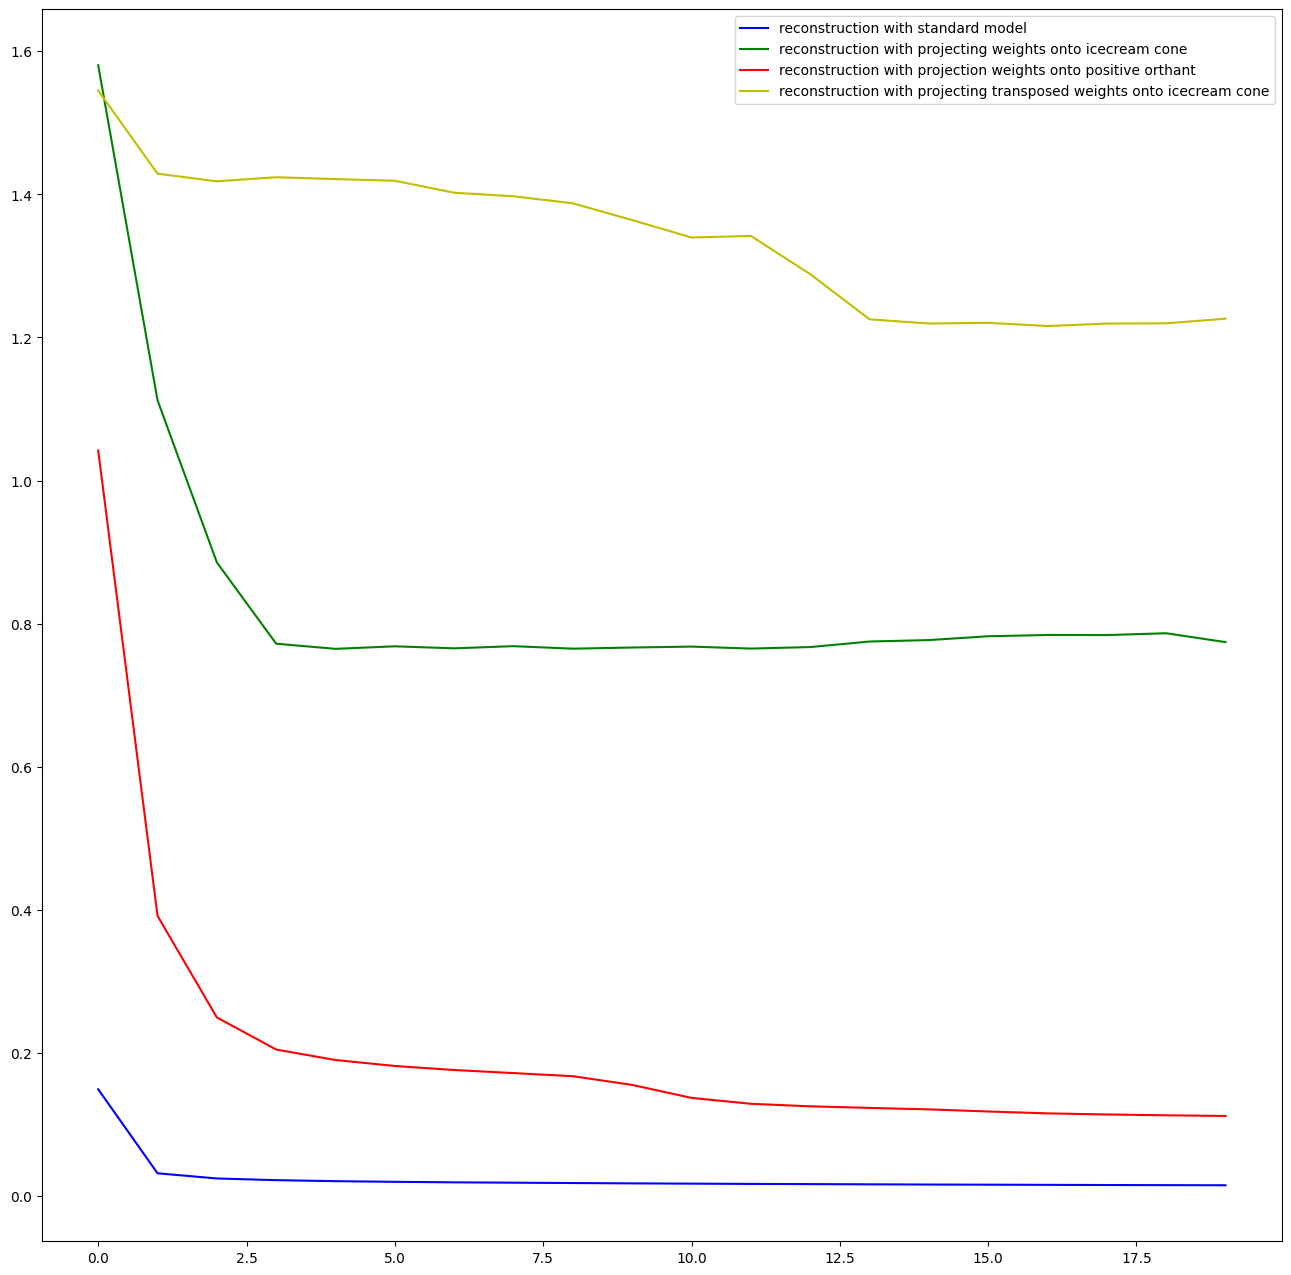

In [ ]:
plt.figure(figsize = (16,16))
plt.plot(normal_loss_total[:], c = 'b', label='reconstruction with standard model')
plt.plot(cone_loss_total[:], c = 'g', label='reconstruction with projecting weights onto icecream cone')
plt.plot(clamp_loss_total[:], c = 'r', label='reconstruction with projection weights onto positive orthant')
plt.plot(cone_t_loss_total[:], c = 'y', label='reconstruction with projecting transposed weights onto icecream cone')
plt.legend(loc="upper right")
plt.savefig("WeightConeProj_AngularPowerSpectra_Adam_Loss.pdf", format='pdf')

In [ ]:
test_examples = None
with torch.no_grad():
    for batch_features in data_loader:
        batch_features = batch_features['aps']
        test_examples = batch_features.view(-1, data_dimension)
        reconstruction_normal = normal_model(test_examples.to(device))
        reconstruction_cone = cone_model(test_examples.to(device))
        reconstruction_clamp = clamp_model(test_examples.to(device))
        reconstruction_cone_t = cone_t_model(test_examples.to(device))
        break

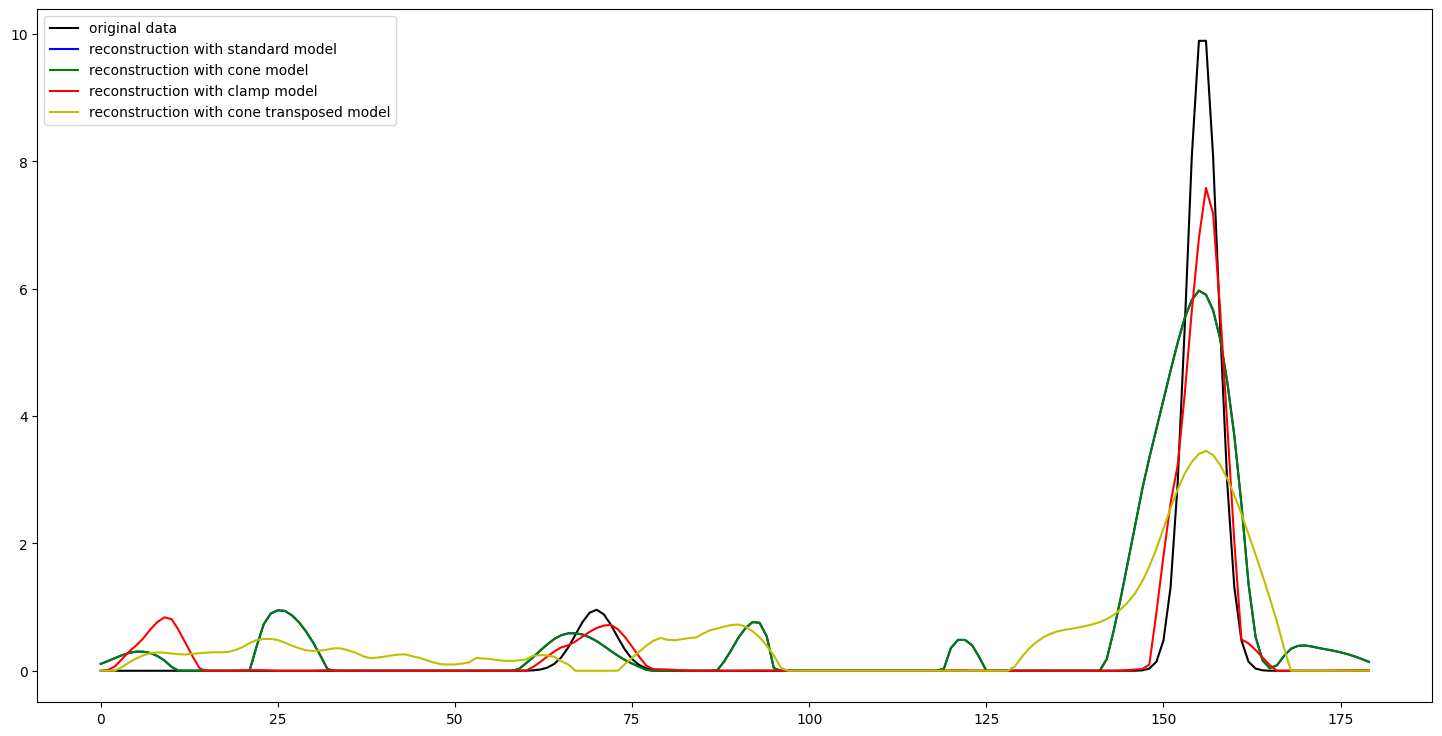

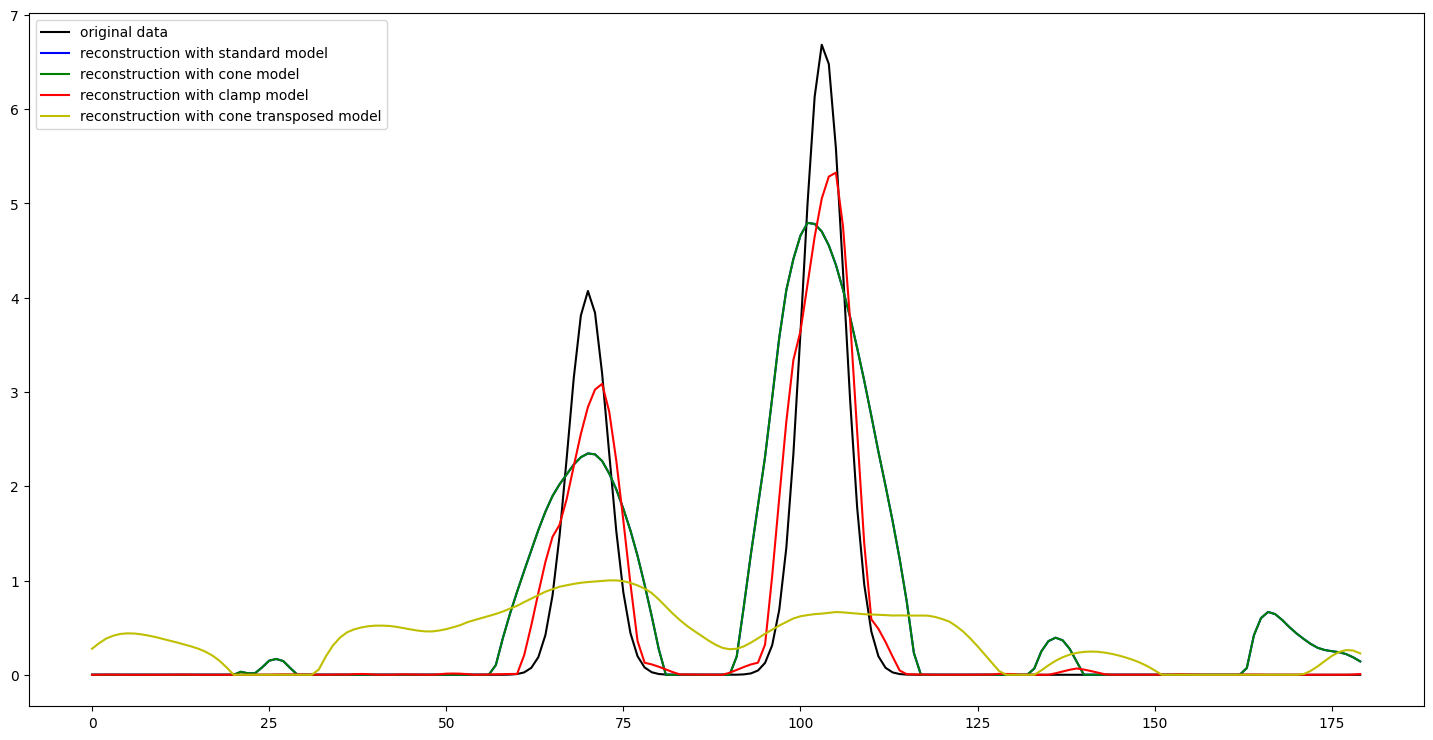

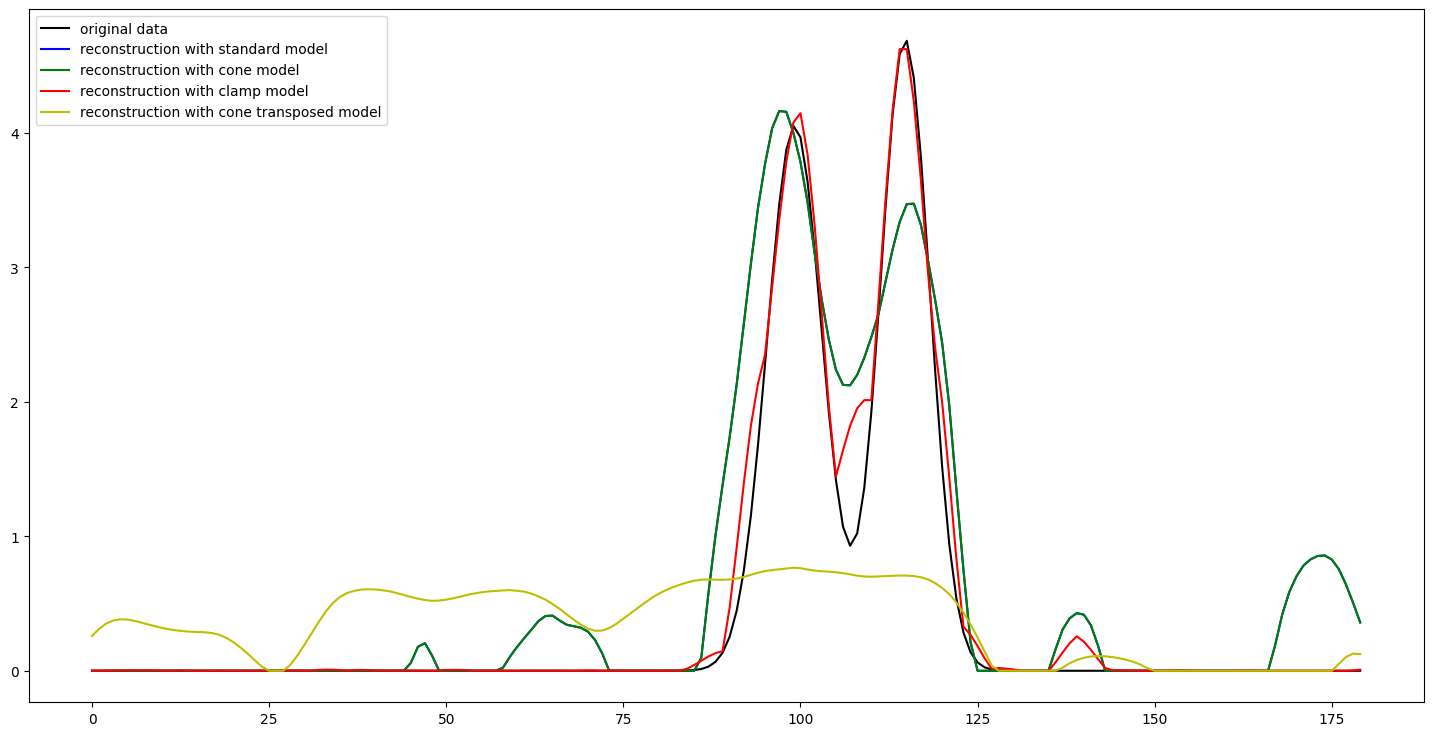

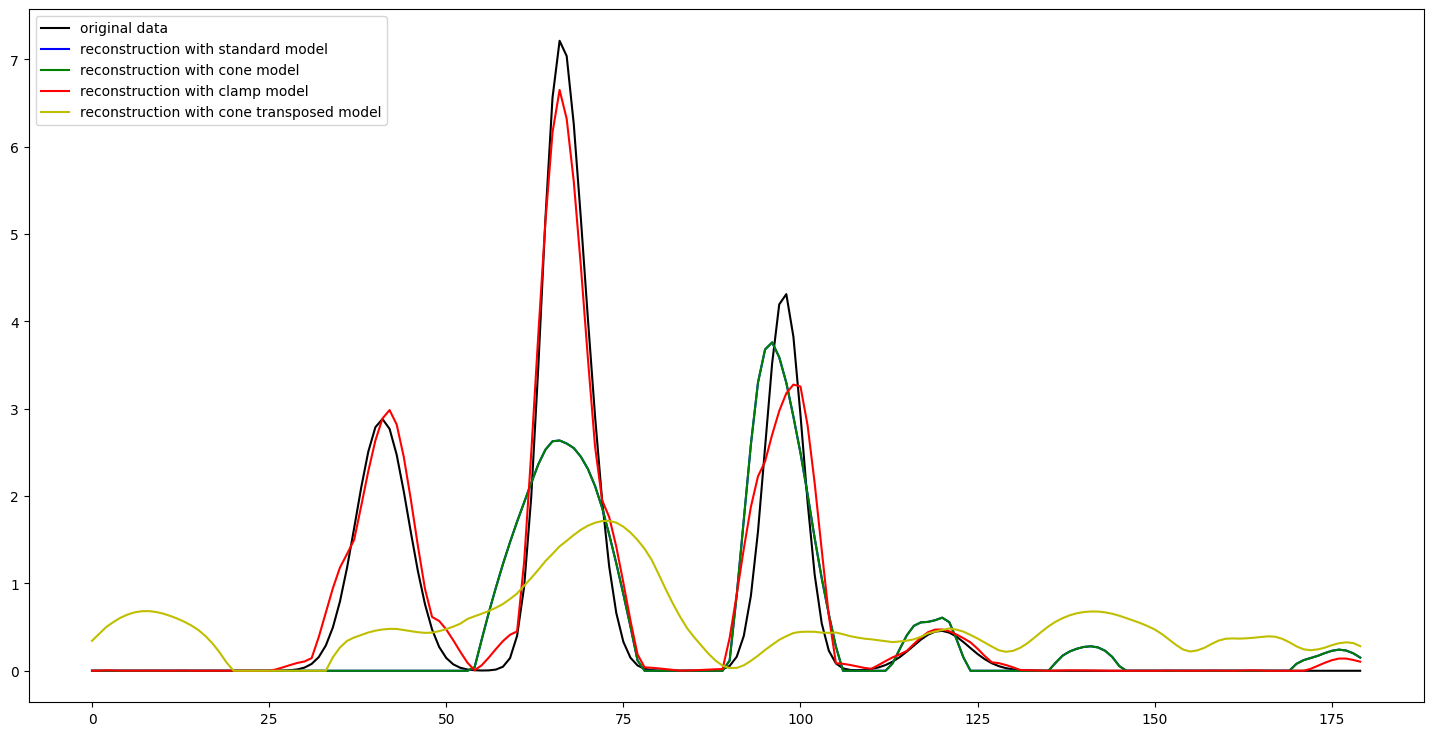

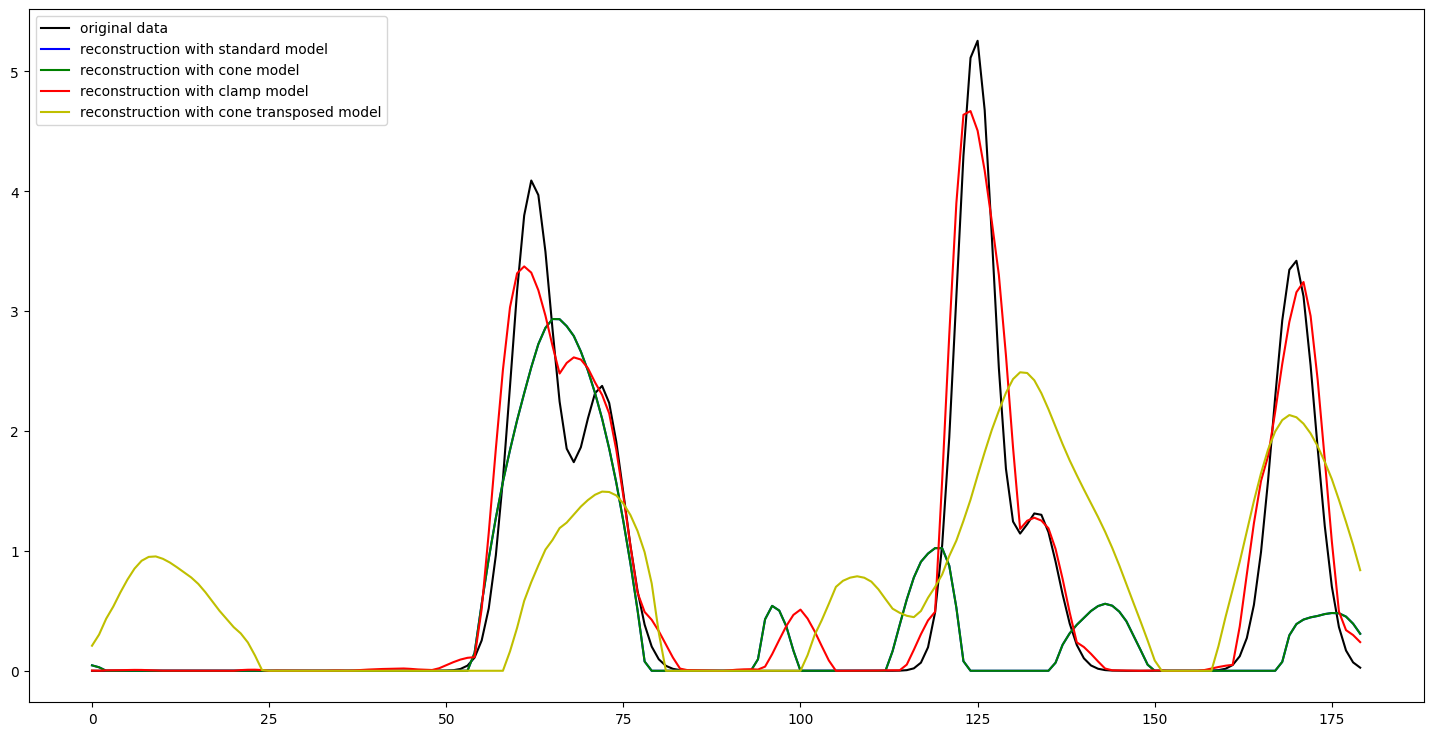

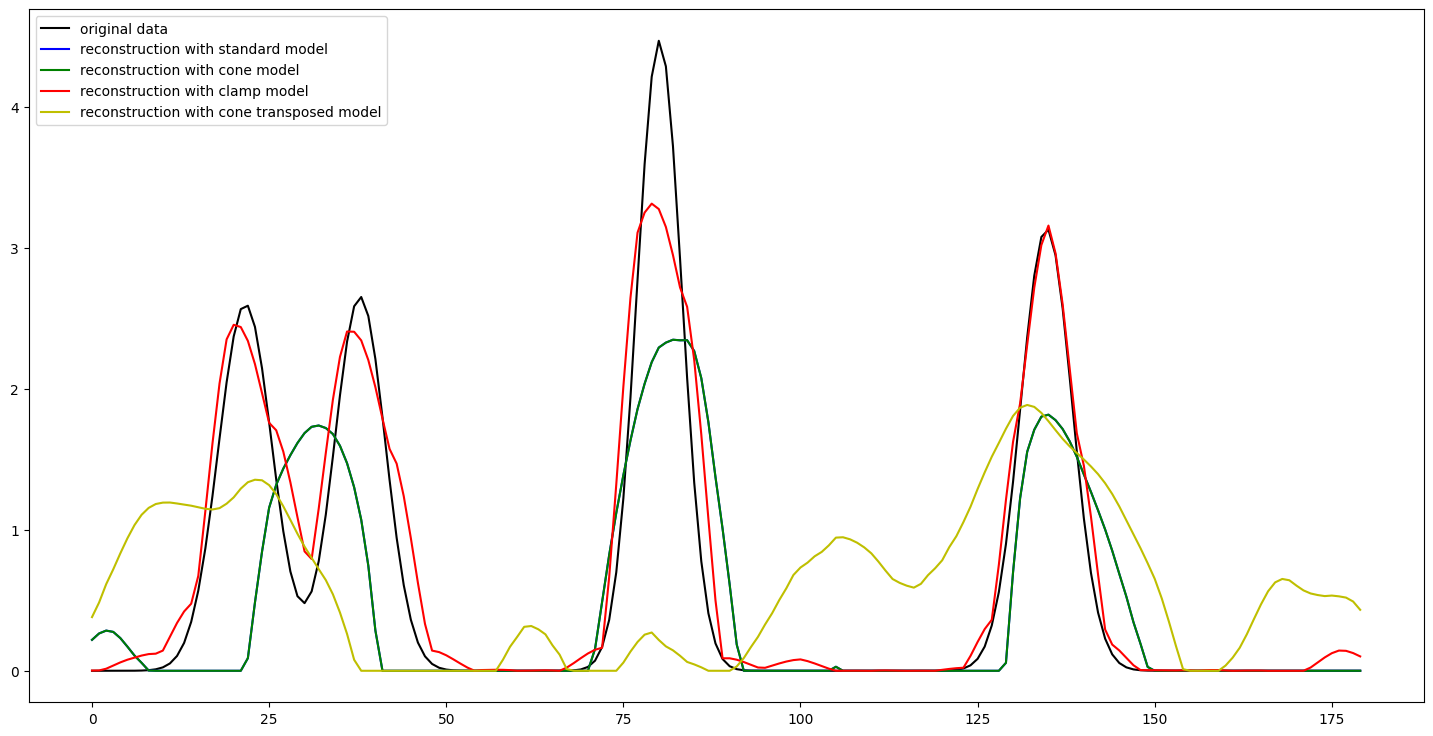

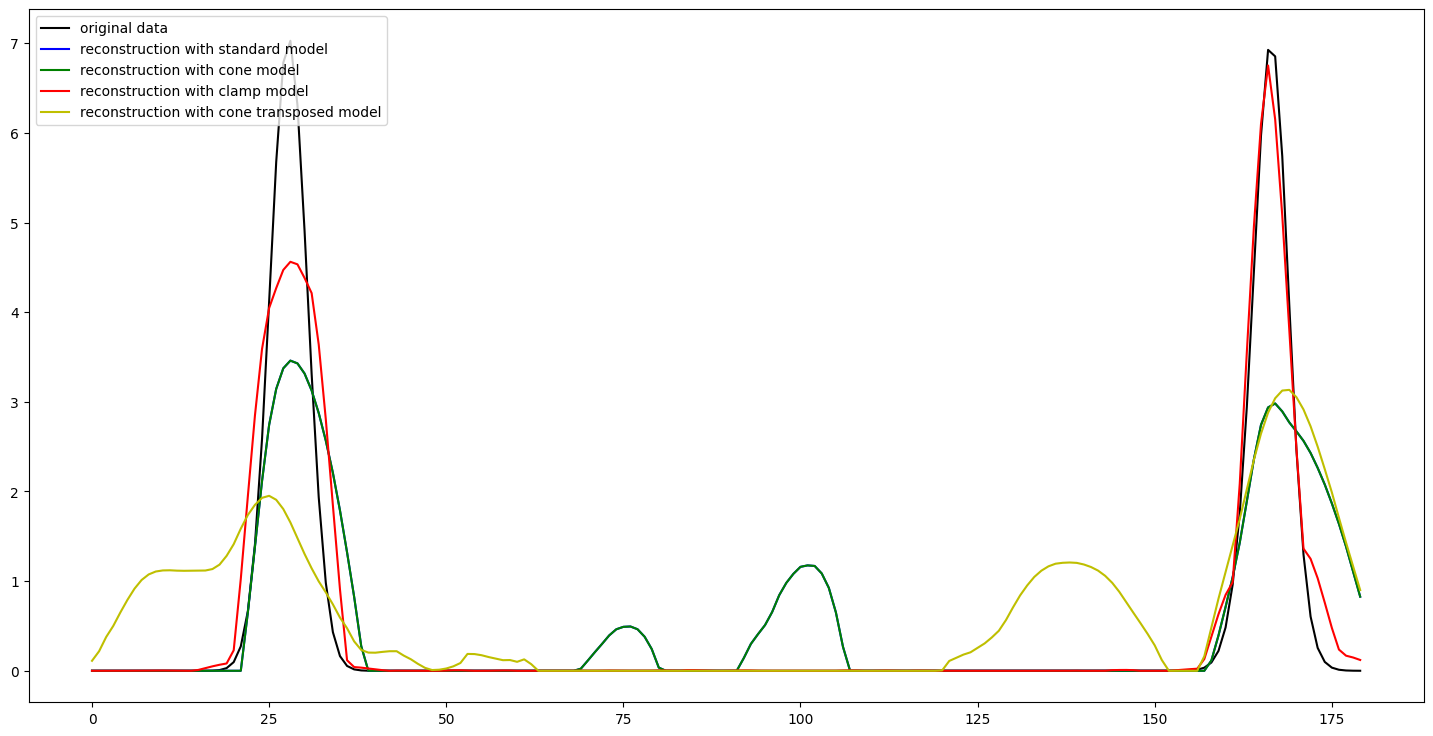

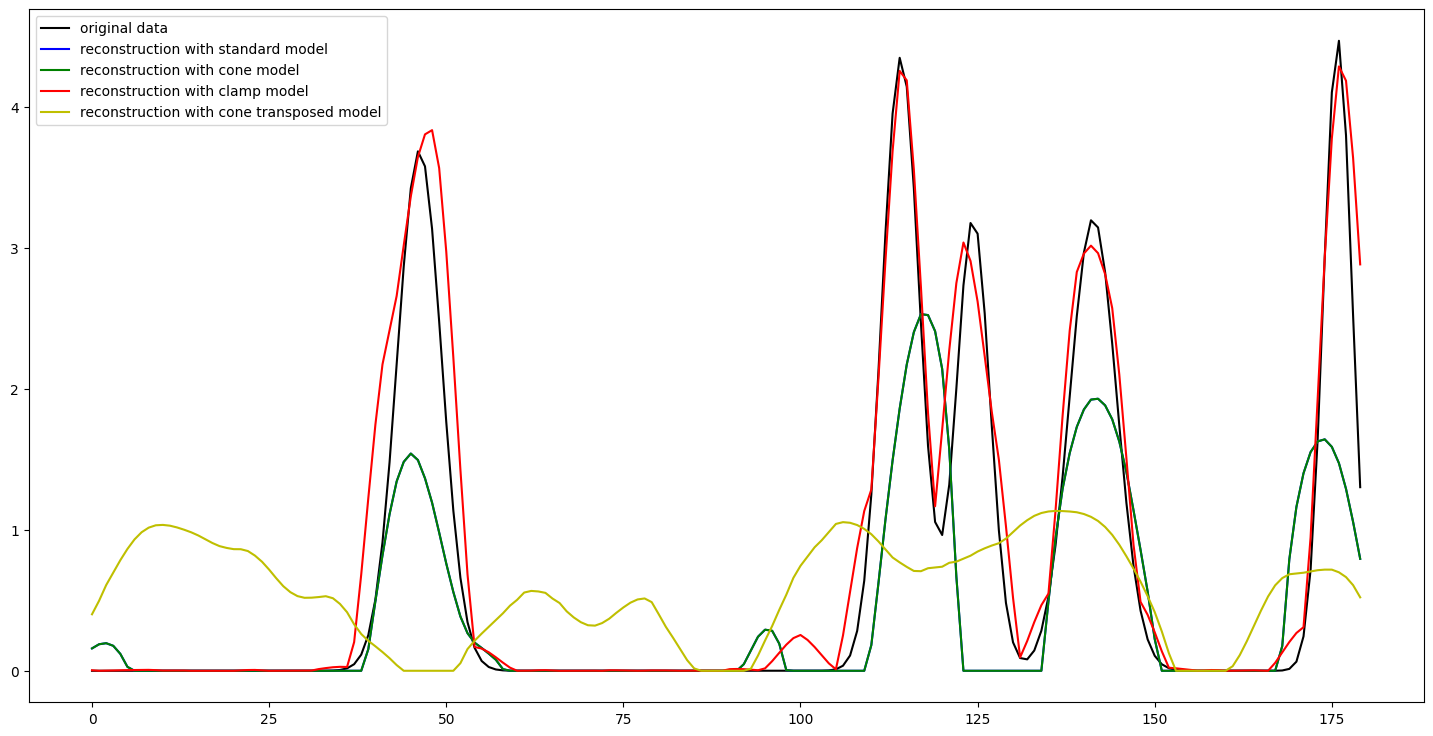

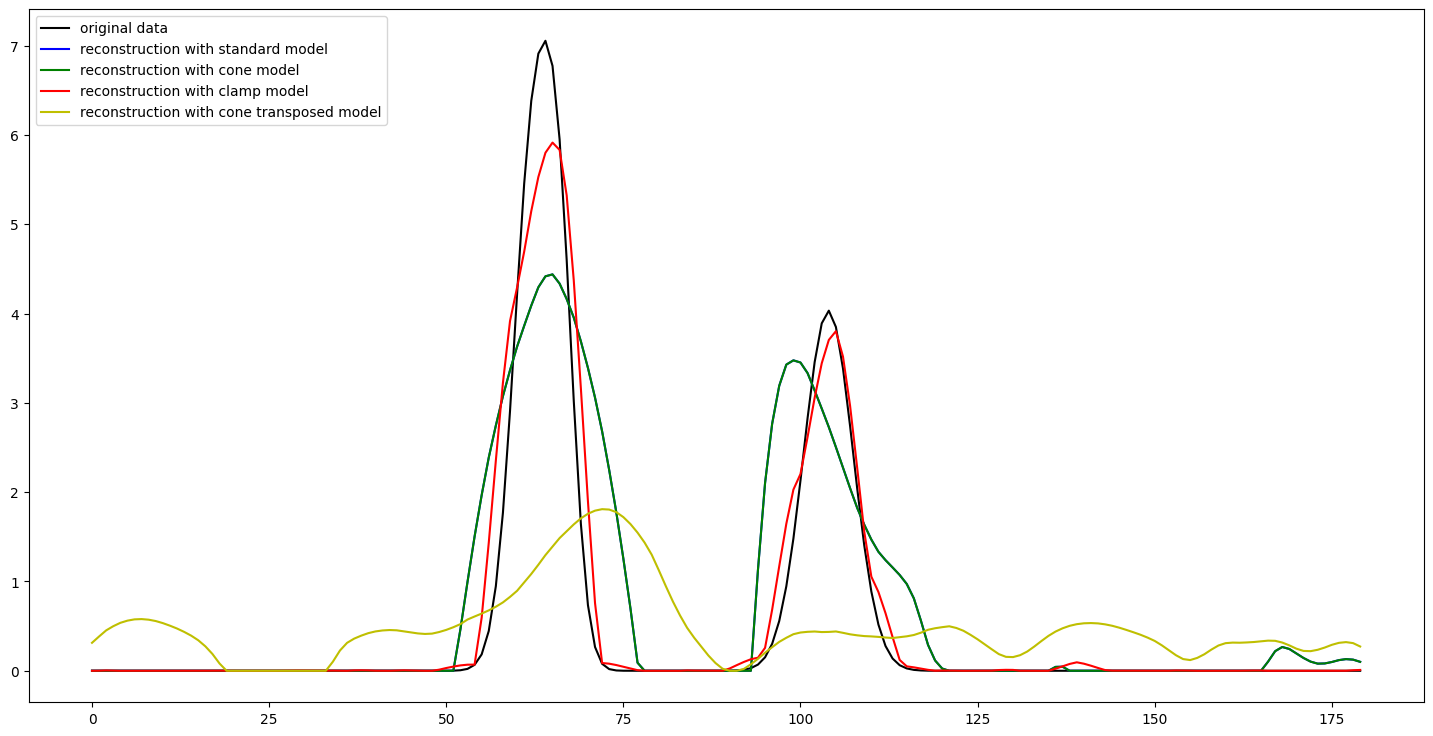

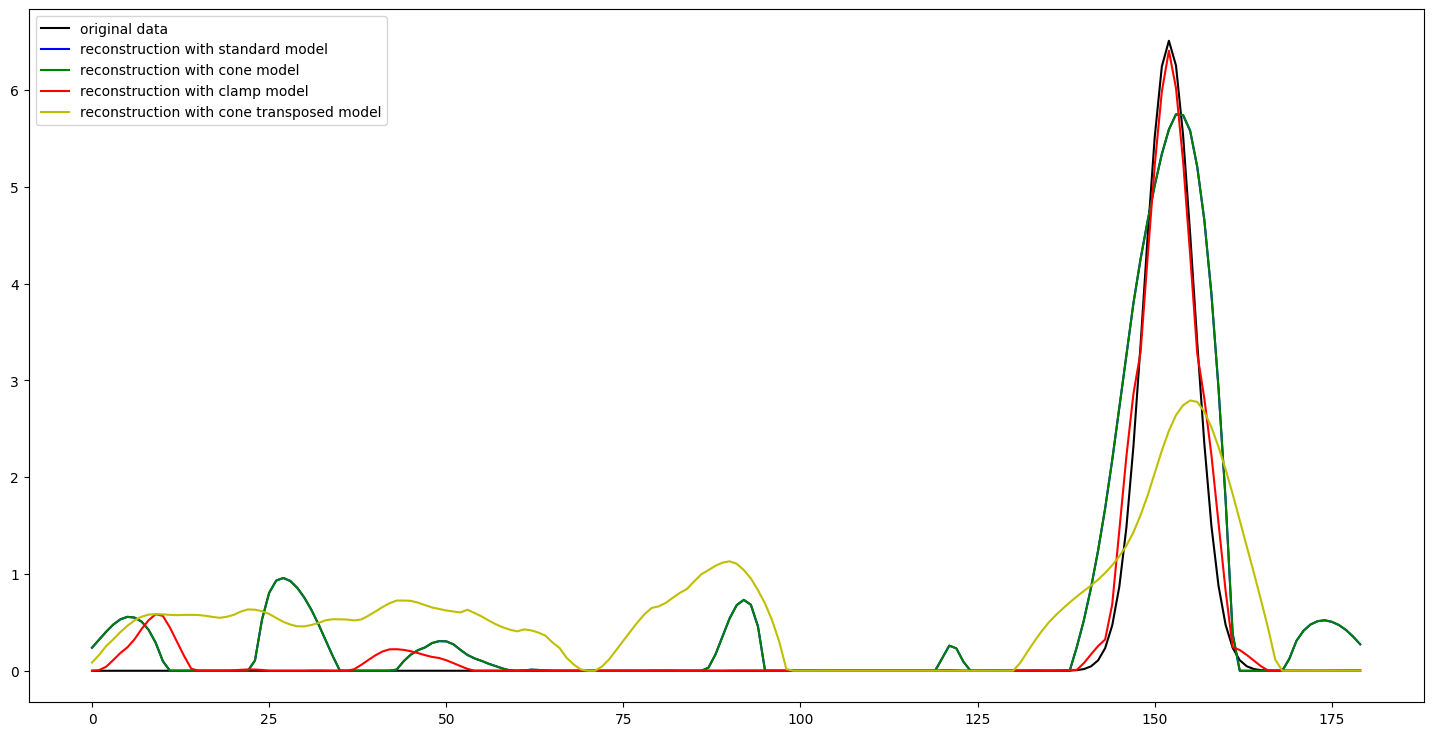

In [ ]:
for idx in range(10):
    plt.figure(figsize=(18, 9))
    f = batch_features[idx, :]
    plt.plot(test_examples[idx], c='k', label='original data')
    plt.plot(reconstruction_cone[idx], c='b', label='reconstruction with standard model')
    plt.plot(reconstruction_cone[idx], c='g', label='reconstruction with cone model')
    plt.plot(reconstruction_clamp[idx], c='r', label='reconstruction with clamp model')
    plt.plot(reconstruction_cone_t[idx], c='y', label='reconstruction with cone transposed model')
    plt.legend(loc="upper left")
    plt.savefig("WeightConeProj_Matis_AngularPowerSpectra_Reconstruction" + str(idx) + ".pdf", format='pdf')

In [ ]:
def ModelComposition(model, n_iter, title, start_point = torch.zeros(1, input_shape)):
  plt.figure(figsize=(16, 9))

  for _ in range(n_iter):
      start_point = model(start_point)

  plt.plot(np.squeeze(start_point.detach().numpy()), '-', markersize=20, linewidth=2)
  plt.grid()
  plt.yscale('symlog')
  plt.xlabel('Coordinate')
  plt.ylabel('Value')
  plt.savefig(title + ".pdf", format='pdf')
  plt.show()

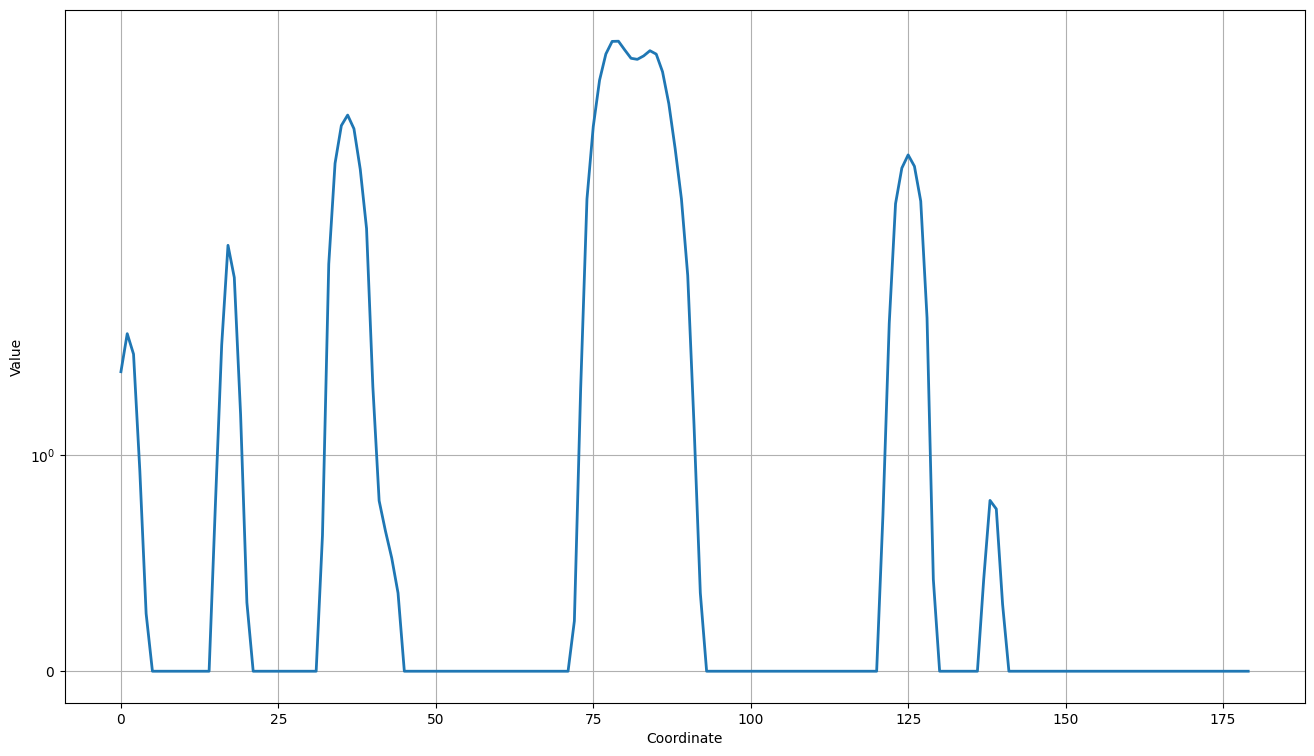

In [ ]:
ModelComposition(normal_model, 10000, "WeightConeProj_AngularPowerSpectra_Adam_FixedPointStandardModel")

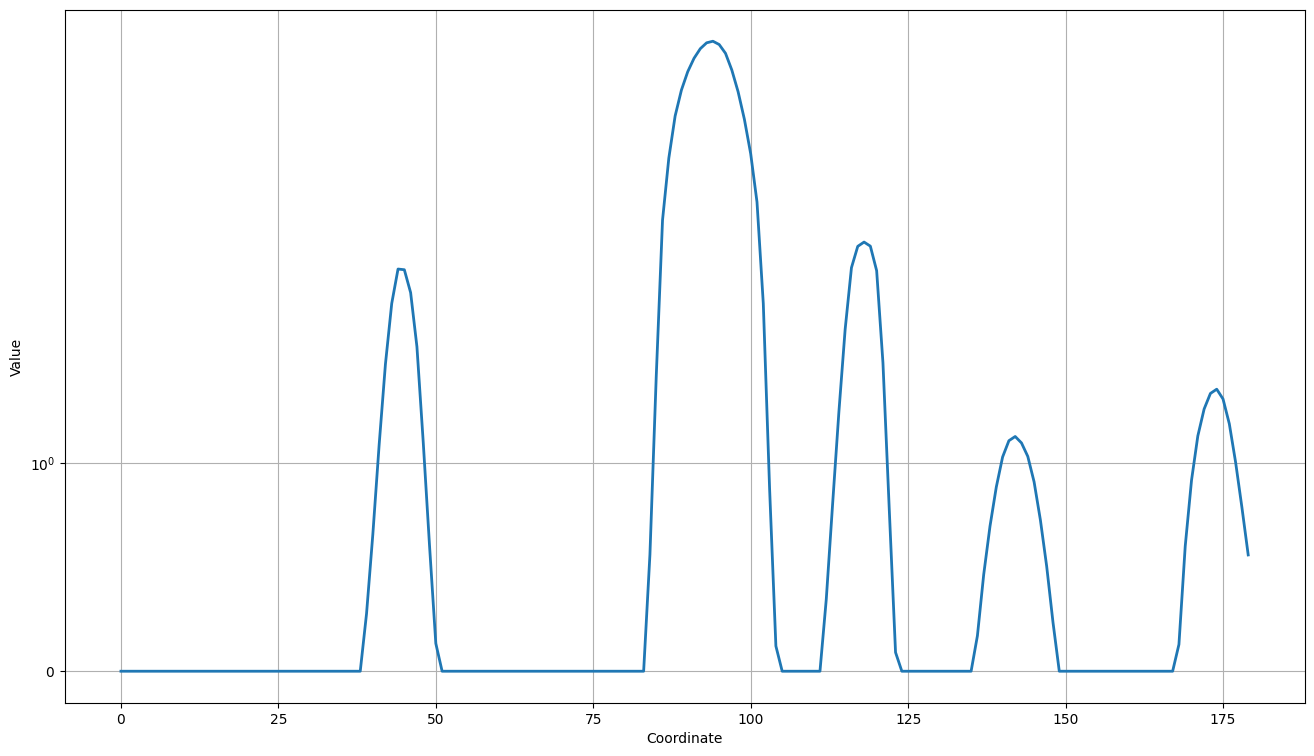

In [ ]:
ModelComposition(cone_model, 10000, "WeightConeProj_AngularPowerSpectra_Adam_FixedPointConeModel")

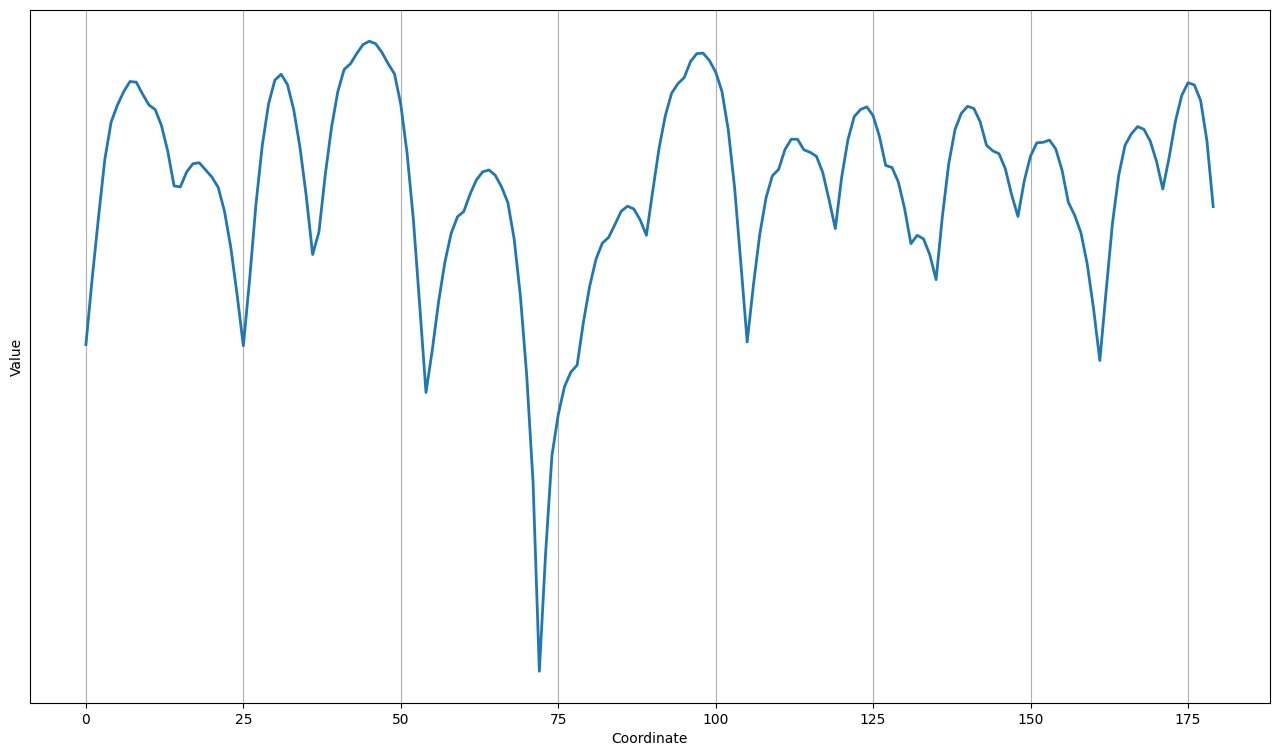

In [ ]:
ModelComposition(clamp_model, 10000, "WeightConeProj_AngularPowerSpectra_Adam_FixedPointClampModel")

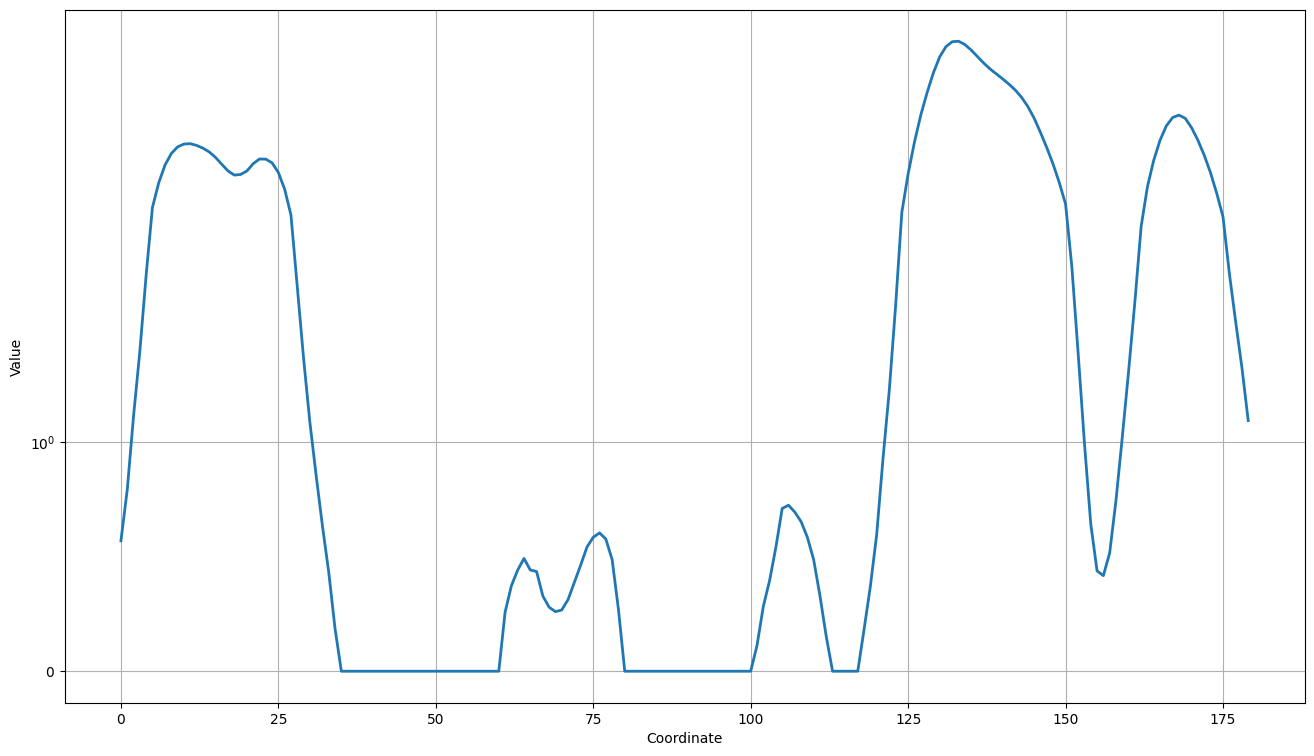

In [ ]:
ModelComposition(cone_t_model, 10000, "WeightConeProj_AngularPowerSpectra_Adam_FixedPointConeTModel")

In [ ]:
def Hinton(model, title):
  param_list = list(model.parameters())
  num_layers = 0
  for i in range(len(param_list)):
      num_layers = num_layers + 1

  matrix = param_list[i - 1].detach().numpy()

  plt.figure(figsize=(16, 16 * matrix.shape[1] / matrix.shape[0]))
  ax = plt.gca()

  max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))
  ax.patch.set_facecolor('gray')
  ax.set_aspect('equal', 'box')
  ax.xaxis.set_major_locator(plt.NullLocator())
  ax.yaxis.set_major_locator(plt.NullLocator())
  for (x, y), w in np.ndenumerate(matrix):
      color = 'white' if w > 0 else 'black'
      size = np.sqrt(abs(w) / max_weight)
      rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                           facecolor=color, edgecolor=color)
      ax.add_patch(rect)
  ax.autoscale_view()
  ax.invert_yaxis()
  plt.savefig(title + ".pdf", format='pdf')

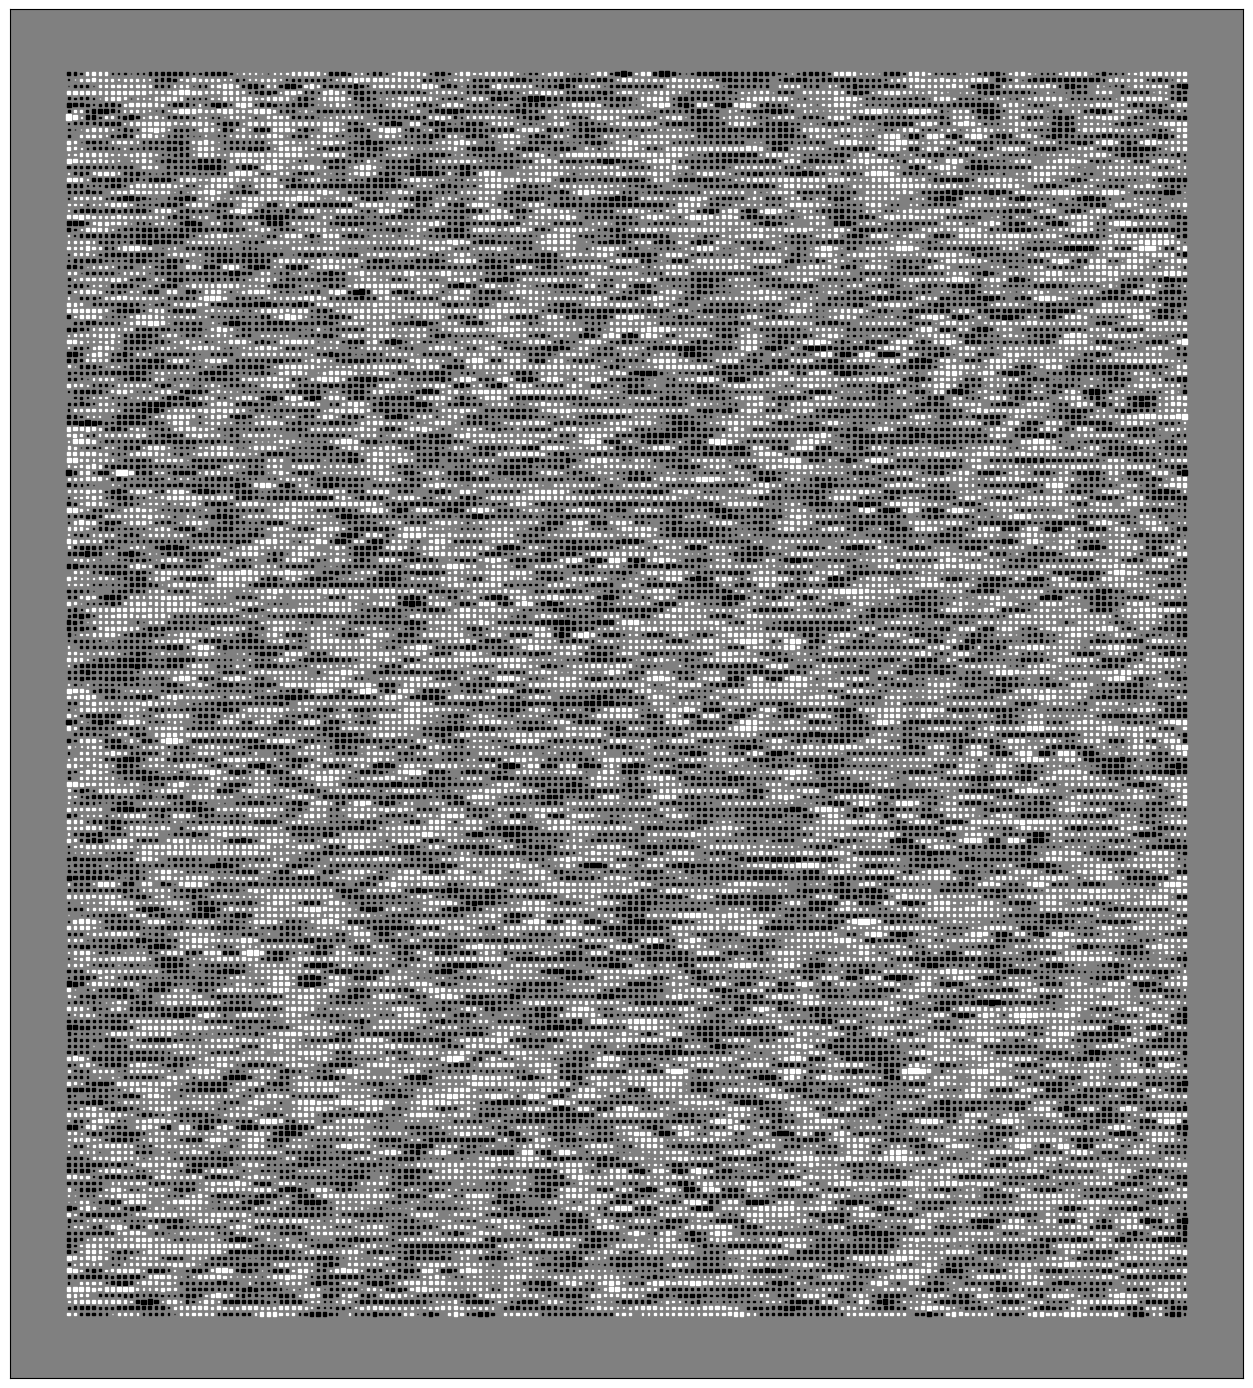

In [ ]:
Hinton(normal_model, "WeightConeProj_AngularPowerSpectra_Adam_HintonStandardModel")

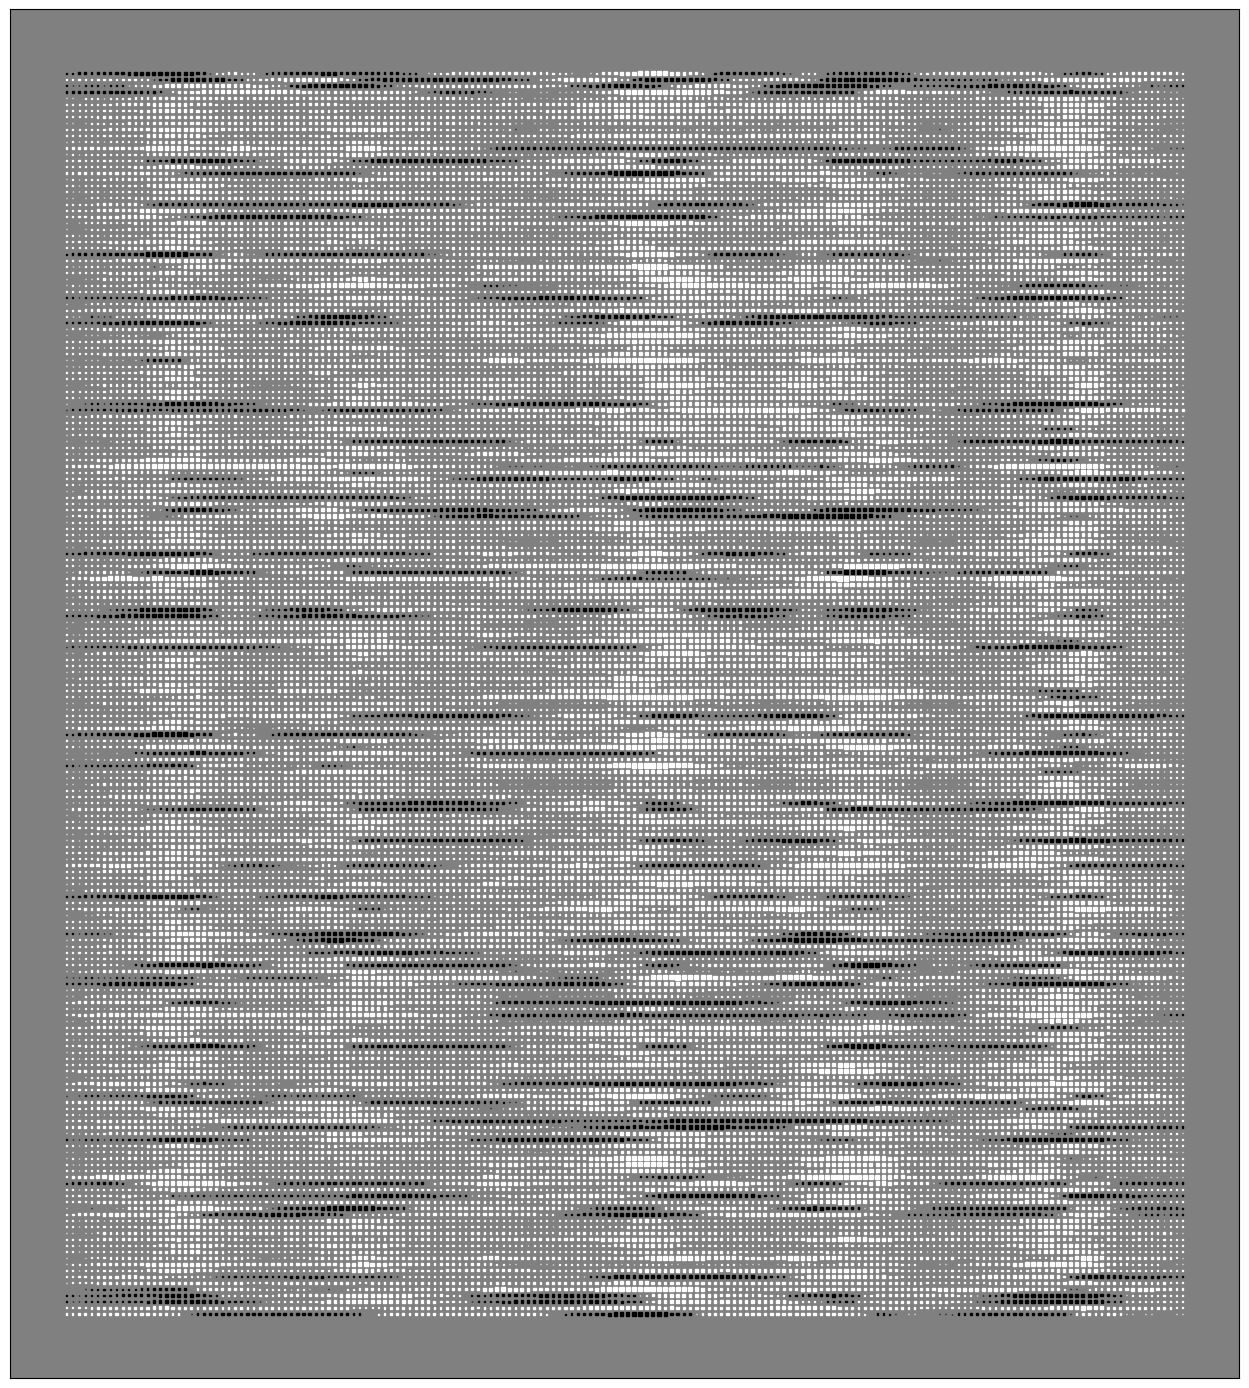

In [ ]:
Hinton(cone_model, "WeightConeProj_AngularPowerSpectra_Adam_HintonConeModel")

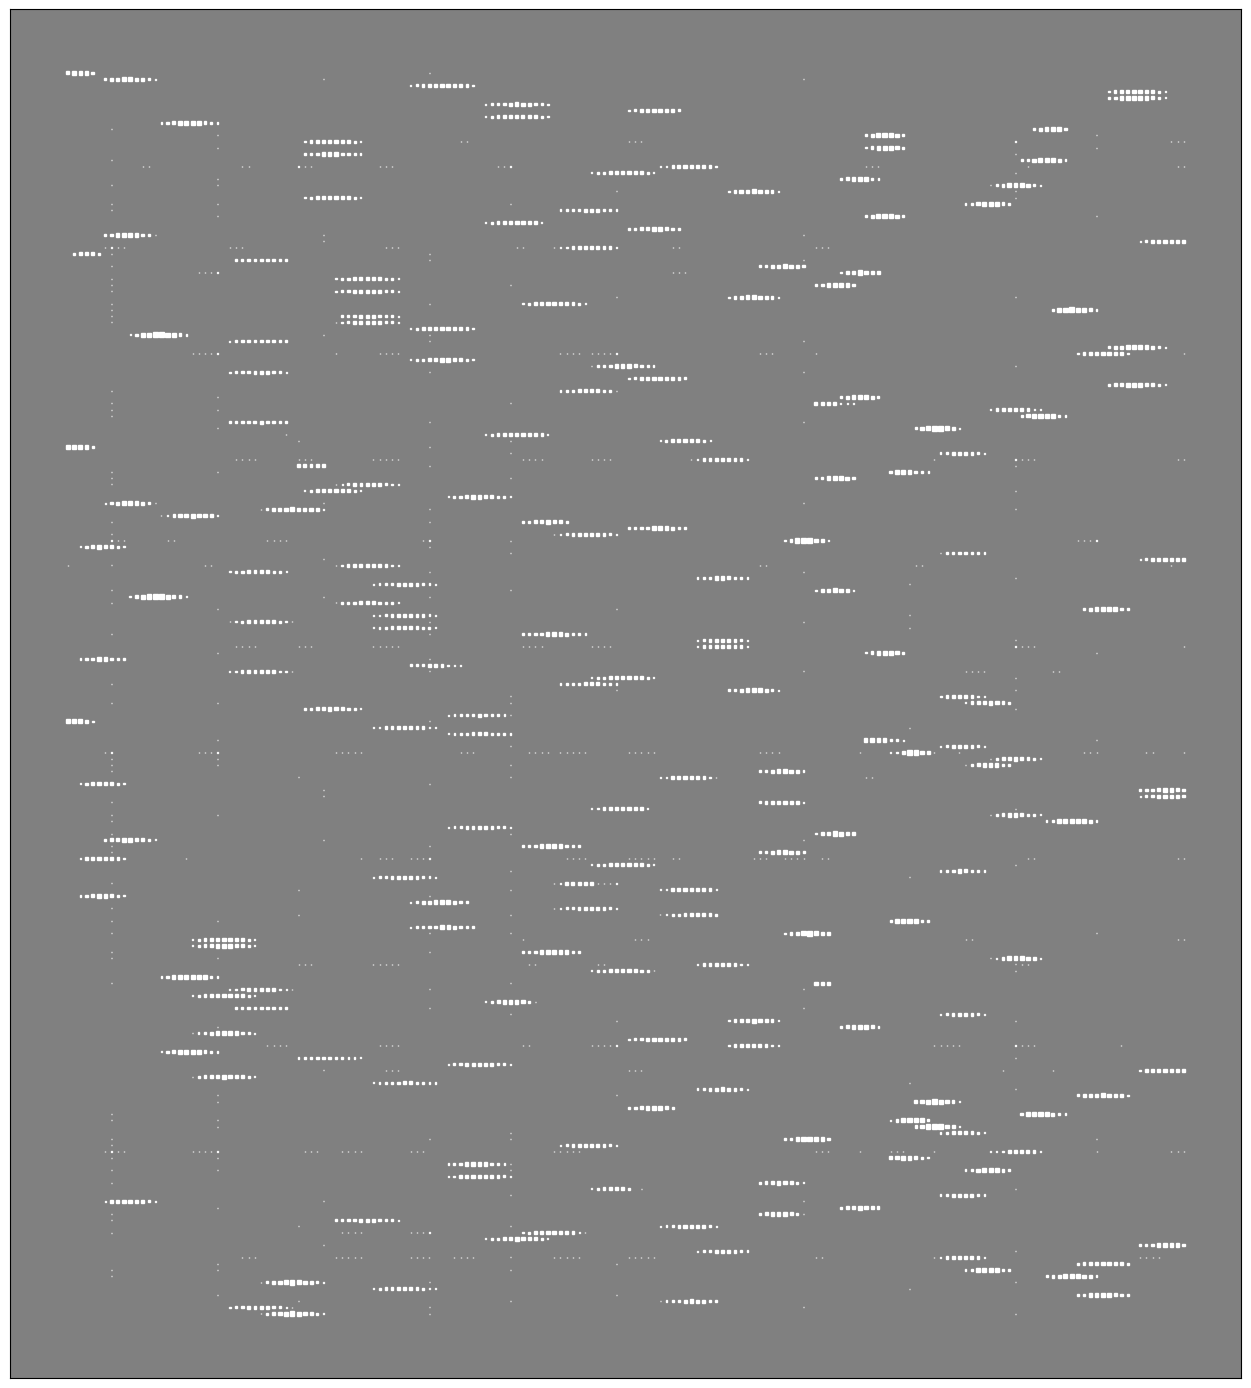

In [ ]:
Hinton(clamp_model, "WeightConeProj_AngularPowerSpectra_Adam_HintonClampModel")

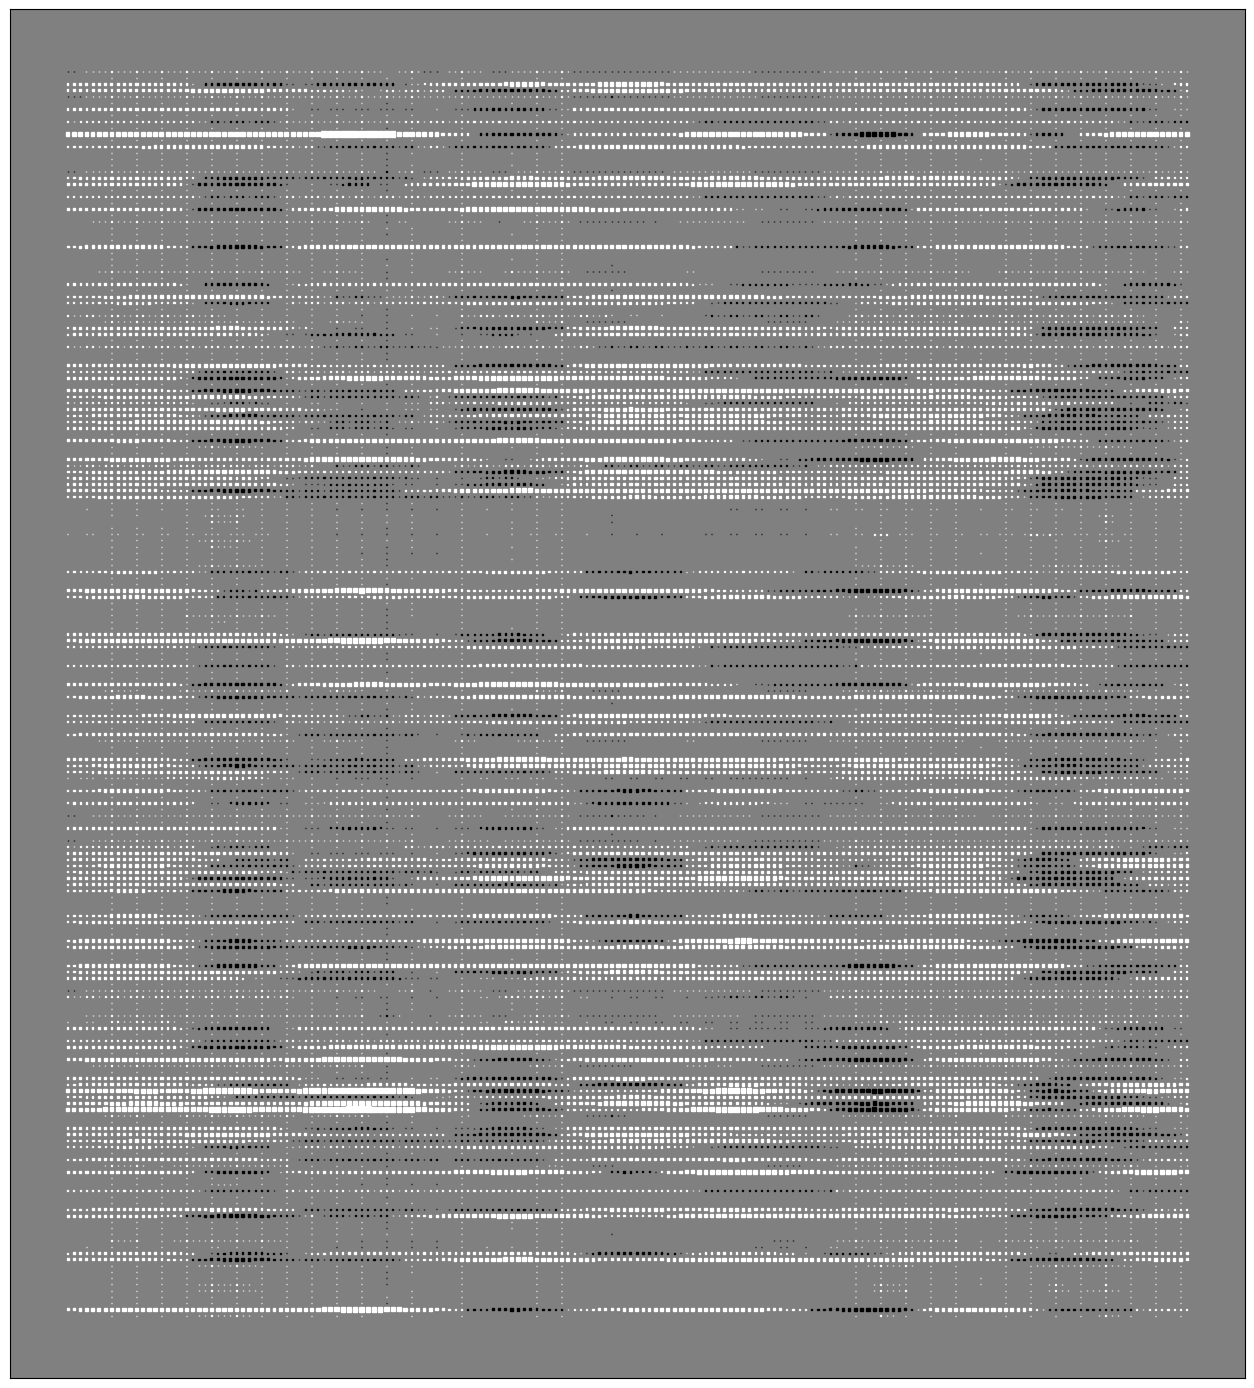

In [ ]:
Hinton(cone_t_model, "WeightConeProj_AngularPowerSpectra_Adam_HintonConeTModel")

In [ ]:
def show_weights(model, title):
  numLayers = 0
  params = list(model.parameters())
  for i in range(len(params)):
    numLayers = numLayers + 1

  plt.figure(figsize=(20,12))
  for i, p in enumerate(params[numLayers - 2].T[:128]):
    plt.grid(True)
    plt.subplot(16, 8, i+1)
    plt.plot(p.detach().numpy())
    plt.xlim([0, 175])
    plt.ylim([-0.3, 0.3])
  plt.savefig(title + ".pdf", format='pdf')

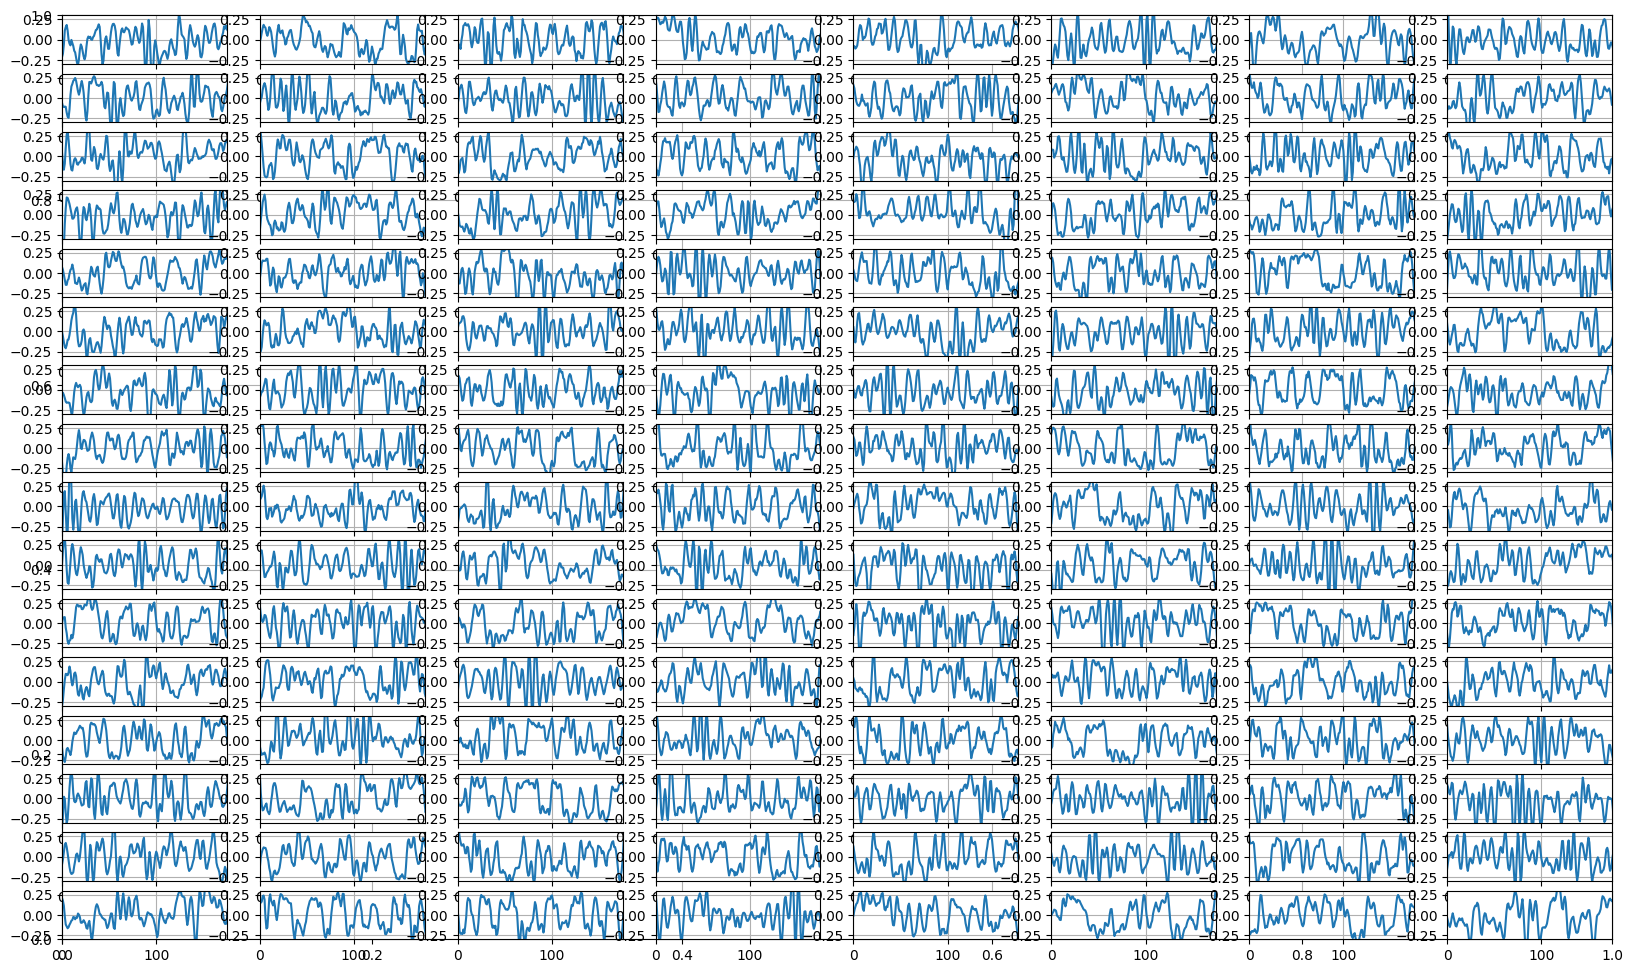

In [ ]:
show_weights(normal_model, "WeightConeProj_AngularPowerSpectra_Adam_WeightsLastLayerStandardModel")

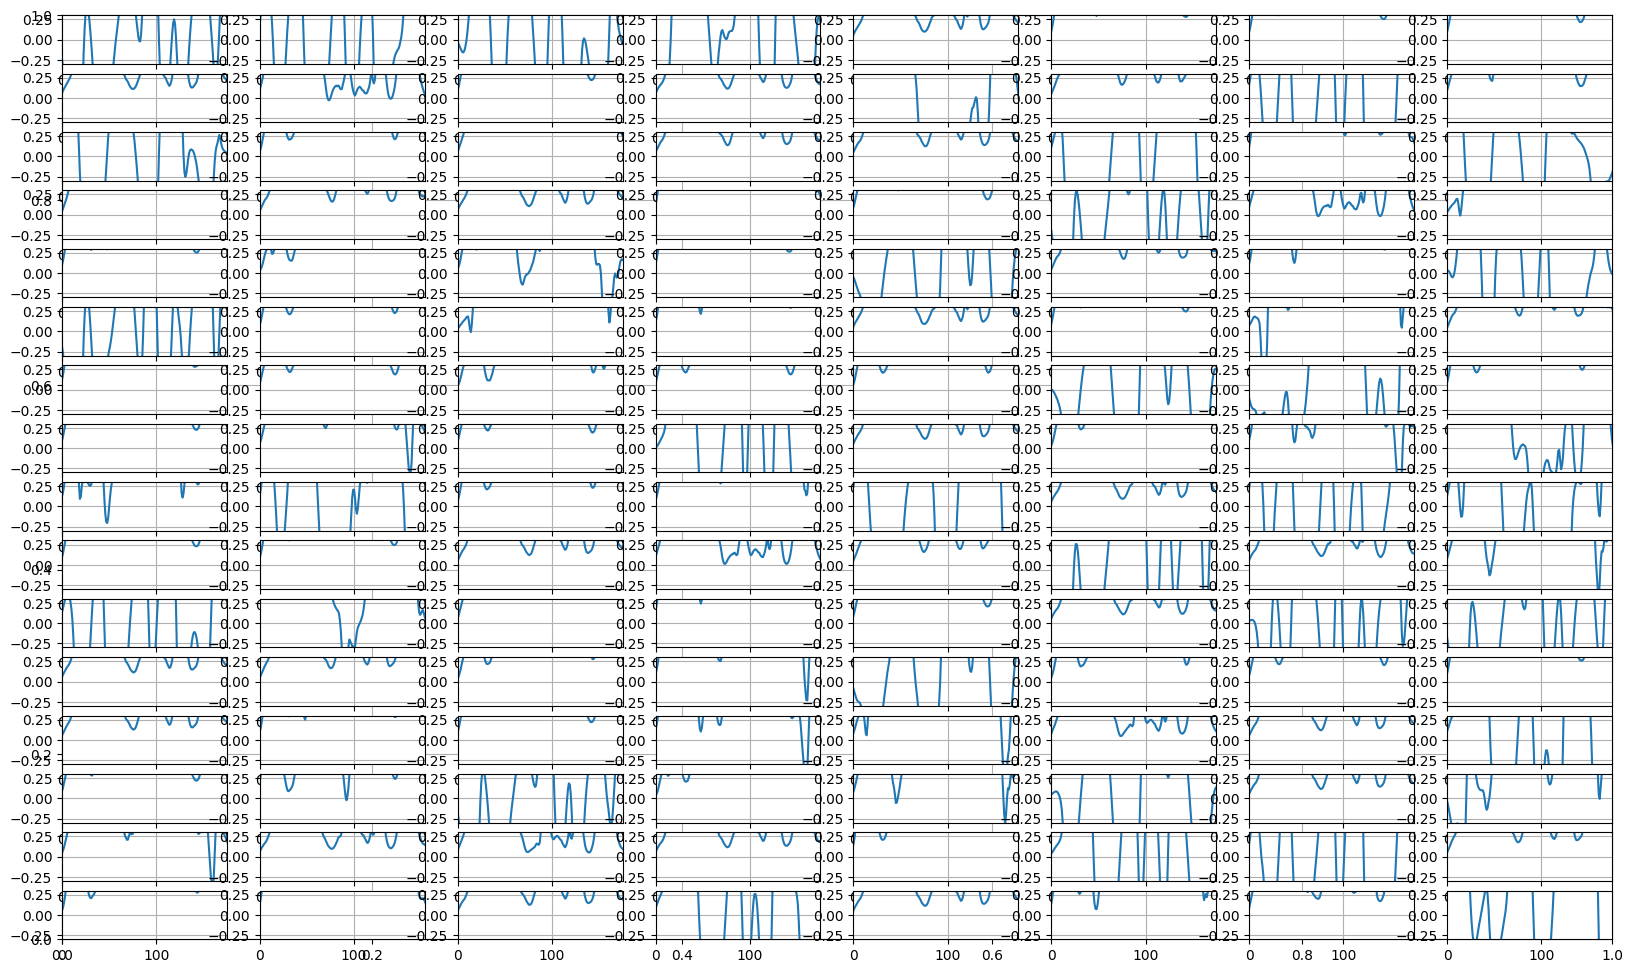

In [ ]:
show_weights(cone_model, "WeightConeProj_AngularPowerSpectra_Adam_WeightsLastLayerConeModel")

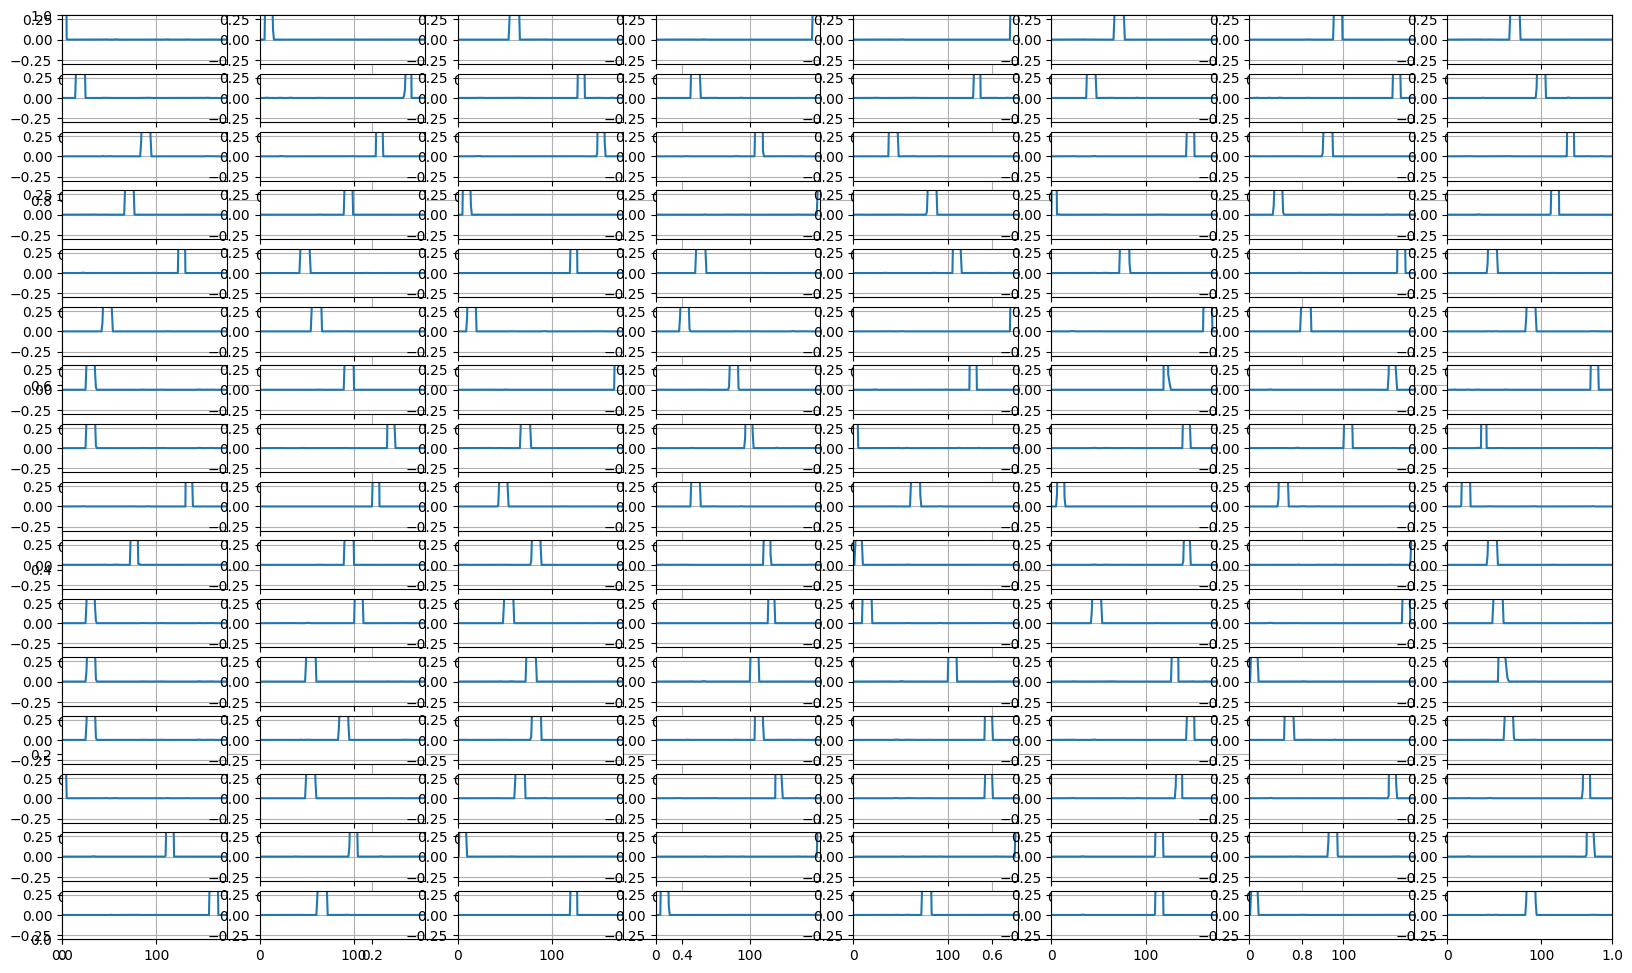

In [ ]:
show_weights(clamp_model, "WeightConeProj_AngularPowerSpectra_Adam_WeightsLastLayerClampModel")

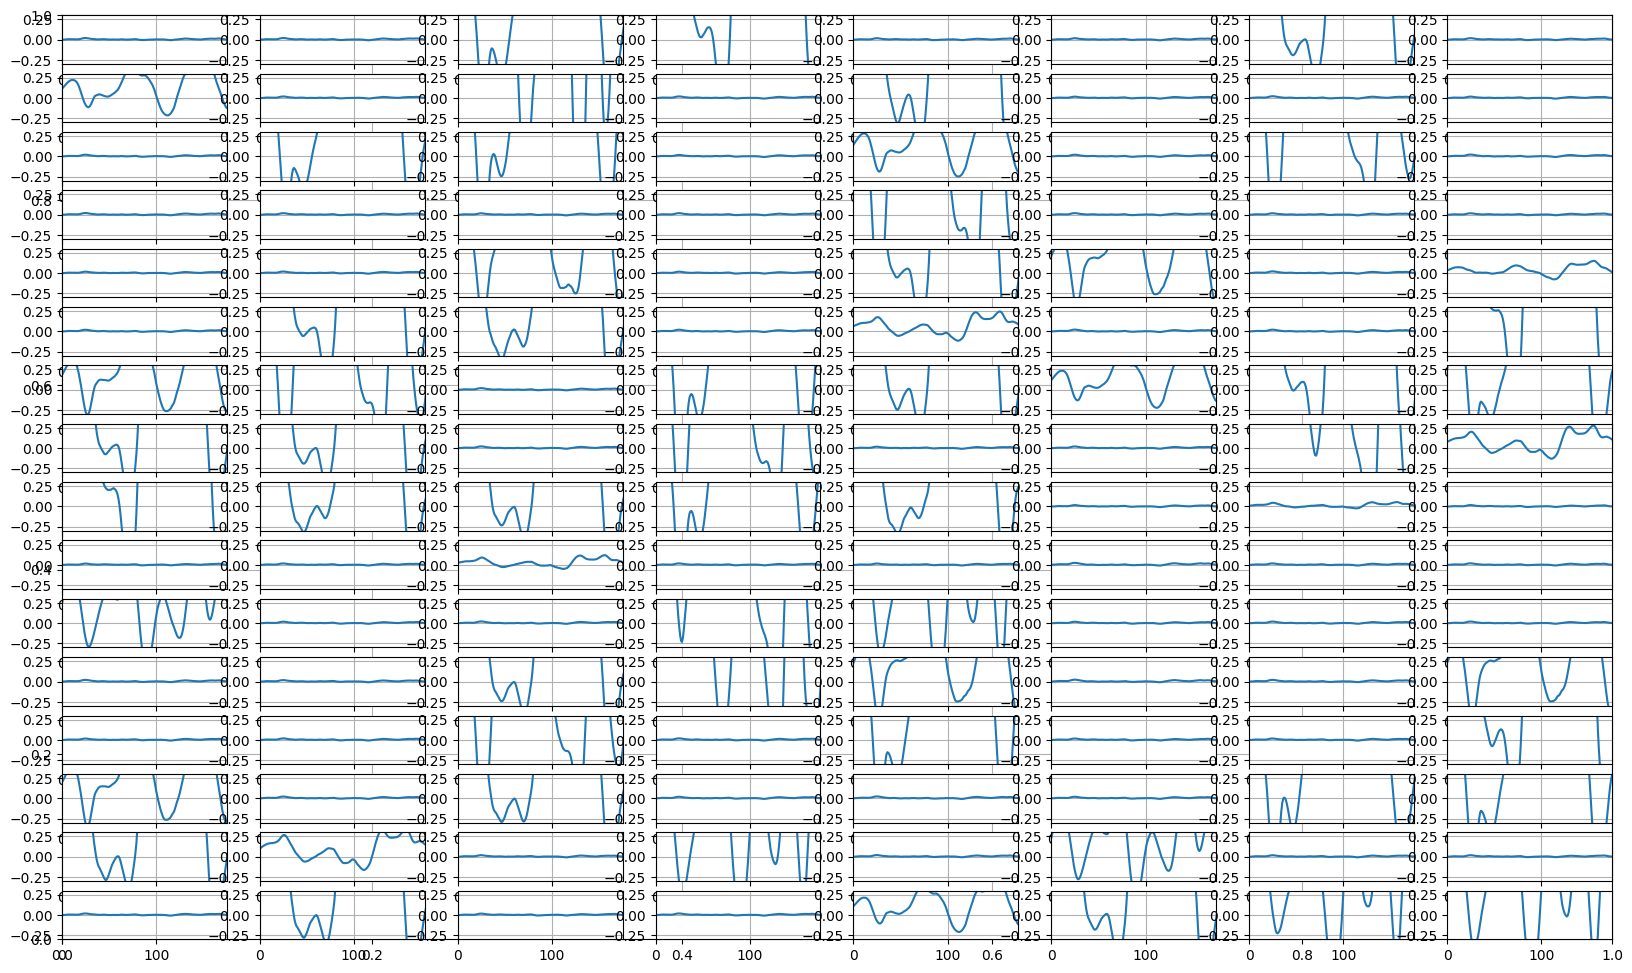

In [ ]:
show_weights(cone_t_model, "WeightConeProj_AngularPowerSpectra_Adam_WeightsLastLayerConeTModel")